# Tiny Japanese to English Translator

- Purpose: To build a model to translate from Japanese to English using deep neural network
- Keywords: Encoder, Decoder, Machine Translation, Pytorch

In [1]:
from io import open
import unicodedata
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
font = {"family":"IPAexGothic"} #Japanese font
plt.rc('font', **font)

In [2]:
# 親ディレクトリのツールをインポート
import sys,os
sys.path.append(os.pardir)
from utilities.NLPtools import *

In [3]:
# cuda利用可能かチェック
use_cuda = torch.cuda.is_available()

In [4]:
# パラメータの初期化
SOS_token = 0
EOS_token = 1

MAX_LENGTH = 10

teacher_forcing_ratio = 0.5
hidden_size = 256

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

In [5]:
# 文字列を小文字へ統一するための関数
def convert_str_to_lower_case(s):
    """
    Replace char to lower letter
    :param s: original string
    :return: converted string
    """
    s = s.lower().strip()
    return s

In [6]:
# 文字のインデックス、文字数を管理するためのクラス
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence, lang_name):
        """
        After splitting to word chunk, update word2index, word2count, index2word list
        :param sentence: input sentence
        :lang_name: name of language
        :return: self instance with updated property
        """
        if lang_name in ['eng', 'fra']:
            for word in sentence.split(' '):
                self.addWord(word)
        elif lang_name == 'jpn':
            wakachi = mcb_tokenize(sentence)
            for word in wakachi:
                self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
# 特定のフォルダから、コーパスを読み込む。初めのカラムに収められる言語名、２番目のカラムに収められる言語名を指定
# 今回は、lang1にeng, lang2にjpnを指定するが、reverseがTrueのため、入力言語がjpn,出力言語がengでテスト
# Langクラスから作られた入力言語及び出力言語のインスタンスに加えて、ペアが収められたリストの３つを返す関数
def readLangs(lang1, lang2, reverse=False):
    """
    Open and read file to create sentence pair
    :param lang1: First language name
    :param lang2: Second language name
    :param reverse: swap lang1 and lang2
    :return: input language, output language and sentence pair
    """
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/machine_translation/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and convert it to lower letter
    pairs = [[convert_str_to_lower_case(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
# コーパスから特定の条件下にあるデータのみ抽出して返す関数
# 条件1: 両言語MAX_LENGTH（１０）トークン未満、 条件2: 出力言語がeng_prefixesに登録されているフレーズで始まる
# つまり今回は、特定のフレーズ（私は、彼は　etc）のみ対応した翻訳モデルを生成する
def filterPair(p):
    """
    If sentences length are less than 10 and English sentence starts with
    prefix like 'i am', 'he is', return True
    :param p: sentence pair
    :return: True if condition is satisfied
    """
    return len(mcb_tokenize(p[0])) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

In [9]:
# filterPair()を用いてコーパスからフィルタリングしたデータのみ収めたリスト（ペア文）を抽出する関数
def filterPairs(pairs):
    """
    Extract pairs to fulfill condition in filterPair
    It is necessary to reduce time and improve accuracy for efficiency for this toy model
    :param pairs: sequence pair list
    :return: filtered sequence pair list
    """
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
# readLangs()によってデータを読み込み、filterPairs()によってフィルタリングしたペア文を
# インスタンスinput_lang、output_langに登録する関数
# 更新されたインスタンス、及びペア文を戻す
def prepareData(lang1, lang2, reverse=False):
    """
    After reading sentence pair from file, filter them out, and append to word2index, word2count, index2word list
    :param lang1: First language
    :param lang2: Second language
    :param reverse: option to swapt lang1 and lang2
    :return: input_lang, output_lang, pairs
    """
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0],input_lang.name)
        output_lang.addSentence(pair[1],output_lang.name)
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    #jpn 4589
    #eng 2988
    return input_lang, output_lang, pairs

In [11]:
# エンコーダRNNクラス
# 埋め込み層とGRU層を使って入力文（第一言語）から符号化されたデータoutputに加え、隠れ層の状態変数を返す
class EncoderRNN(nn.Module):
    """
     A GRU based seq2seq network that outputs embedded value for every word
     from the input sentence
     For every input word the encoder outputs a vector and a hidden state,
     and uses the hidden state for the next input word.
     input->embedding->embedded->gru-> output
     prev_hiddedn-------^           -> hidden
    """
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [12]:
# デコーダRNNクラス
# 埋め込み層とGRU層を使って入力文（第２言語）から符号化されたデータoutputに加え、隠れ層の状態変数を返す
class DecoderRNN(nn.Module):
    """
    A simple decoder to takes the encoder output vector(s) and outputs
    a sequence of words to create the translation.
    input->embedding->relu->gru->out->softmax->output
    prev_hiddedn-------^       --------------->hidden
    """
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


In [13]:
# アテンションメカニズム付きデコーダRNNクラス
class AttnDecoderRNN(nn.Module):
    """
    Decoder with Attention which allows the decoder network to “focus” on a different part
    of the encoder’s outputs for every step of the decoder’s own outputs.
    """
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            #self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        #output = F.log_softmax(self.out(output[0]), dim=1)
        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [14]:
#文をトークナイズした後、インデックスに置き換え、リストとして返す関数
def indexes_from_sentence(lang, sentence):
    """
    Extract indexes from a sentence (sentence->word->index)
    :param lang: language
    :param sentence: input sentence
    :return: list of indexes
    >>> lang.name
    >>> 'jpn'
    >>> sentence
    >>> '俺はいかしてる。'
    >>>  [652, 2632, 477, 3003, 5, 1]
    """
    if lang.name in ['eng', 'fra']:
        return [lang.word2index[word] for word in sentence.split(' ')]
    if lang.name == 'jpn':
        return [lang.word2index[word] for word in mcb_tokenize(sentence)]



In [15]:
# indexes_from_sentence（）によって文からワードインデックスのリストを取得したのち、
# Variableテンソル形式に変換した値を返す関数
def variable_from_sentence(lang, sentence):
    """
    Convert every word into index and put them together with EOS
    After that, change the indexes to Variable format
    Size of result is determined based on sentence length
    (No need to be fixed always)
    :param lang: language
    :param sentence: input sentence
    :return: Variables of a sentence
    """
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


In [16]:
# 入力文、出力文のVariableテンソルを取得する関数
def variables_from_pair(pair):
    """
    Generate sentence index Variables for input and output
    Then create a list to store them as pair
    :param pair: sentence pair
    :return: Variable sentence index pair
    """
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)



In [17]:
# 秒を分に変換する関数
def as_minutes(s):
    """
    Convert second to minutes and second
    :param s: second
    :return: minutes and second string
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [18]:
# 経過時間を算出する関数
def time_since(since, percent):
    """
    Calculate time since 'since'
    :param since: started time
    :param percent:
    :return:
    """
    now = time.time()
    s = now - since  # erapsed time [s]
    es = s / (percent)  # erapsed time [ratio]
    rs = es - s  # remaining time
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [19]:
# データポイントを描画する関数
def show_plot(points):
    """
    Prepare plot data
    :param points: plot data point
    :return: None
    """
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [20]:
# 入力variable, 出力variable, エンコーダ、デコーダなどを元に、損失を計算する関数
def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Perform training
    :param input_variable:
    :param target_variable:
    :param encoder:
    :param decoder:
    :param encoder_optimizer:
    :param decoder_optimizer:
    :param criterion:
    :param max_length:
    :return: Loss data
    """
    # Initialization
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Encoding
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    # Decoding
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    # use_teacher_forcing is activated randomly (once in every twice)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # Calculate loss function
            loss += criterion(decoder_output, target_variable[di])

            # Teacher forcing
            decoder_input = target_variable[di]

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # Calculate input to decoder
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            # Calculate loss function
            loss += criterion(decoder_output, target_variable[di])

            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [21]:
# 指定されたn_iters回数分イテレーションを行い、train()で計算した損失をprintし、プロットする関数
def train_iters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    """
    Perform training in each iteration
    :param encoder: encoder instance
    :param decoder: decoder instance
    :param n_iters: number of iteration
    :param print_every: timing to print
    :param plot_every: timing to plot
    :param learning_rate: learning rate
    :return: None
    """
    # Initiazliaation
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # Define opimizer
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # Randomly pick up variable pairs
    training_pairs = [variables_from_pair(random.choice(pairs)) for i in range(n_iters)]

    # Define criteria to compute loss function
    criterion = nn.NLLLoss()

    # In every iteration, calculate loss using train() function
    # The loss is used for print and plot
    for iter in range(1, n_iters + 1):

        # Extract a variable pair for training
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        # Compute loss
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # Print loss data
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            # 11m 20s (- 158m 47s) (5000 6%) 2.9332
            # 23m 19s (- 151m 34s) (10000 13%) 2.3810
            # ..
            # 174m 24s (- 0m 0s) (75000 100%) 0.6343

        # Plot loss data
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # Prepare data for plot (Later the data is shown in show_attention())
    show_plot(plot_losses)


In [22]:
# 評価用にsentenceで与えた入力文を、訓練後のencoder, decoderを使って出力文を生成する関数
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
    Perform encoding and decoding for evaluation
    :param encoder: encoder instance
    :param decoder: decoder instance
    :param sentence: input sentence
    :param max_length: maximum length of encoder output
    :return: decoded words and attention
    """
    # Prepare input variable
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]

    # Prepare variable for encoder
    encoder_hidden = encoder.initHidden()
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    # Perform encoding
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    # Prepare variable for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    # Perform decoding
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]


In [23]:
# コーパスからランダムに入力文を選出し、翻訳した後その出力を原文ペアと共にprintする関数
def evaluate_randomly(encoder, decoder, n=10):
    """
    Randomly pickup sentence pair
    :param encoder: encoder instance
    :param decoder: decoder instance
    :param n: numbers of evaluation
    :return: None
    """
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        # > vous etes aveuglee par l amour .
        # = you are blinded by love .
        # < you are blinded by love . <EOS>

In [24]:
# Attention の描画
def show_attention(input_sentence, output_words, attentions):
    """
    Show attention graphically
    :param input_sentence:
    :param output_words:
    :param attentions:
    :return:
    """
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + mcb_tokenize(input_sentence) + ['<EOS>'], rotation=90)
    
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [25]:
# サンプル文による評価の実行、及びアテンションの描画
def evaluate_and_show_attention(input_sentence):
    """
    Perform evaluaton and plot figures (loss, attention) for sample input sentence
    :param input_sentence: input sentence
    :return: None
    """
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)


In [26]:
# コーバス読み込みと情報表示
input_lang, output_lang, pairs = prepareData('eng', 'jpn', True)


Reading lines...
Read 42093 sentence pairs
Trimmed to 1166 sentence pairs
Counting words...
Counted words:
jpn 1289
eng 1161


In [27]:
# サンプル入出力文表示
print(random.choice(pairs))

['彼女はスケートが出来る。', 'she is able to skate.']


In [28]:
# エンコーダ　インスタンスの生成
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)

In [29]:
# デコーダインスタンス（アテンションメカニズム付き）の生成
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,  1, dropout_p=0.1)

5m 31s (- 77m 16s) (5000 6%) 2.8059
10m 36s (- 68m 56s) (10000 13%) 1.8849
15m 47s (- 63m 9s) (15000 20%) 1.0232
21m 6s (- 58m 2s) (20000 26%) 0.4375
26m 42s (- 53m 25s) (25000 33%) 0.1726
32m 5s (- 48m 7s) (30000 40%) 0.1038
37m 19s (- 42m 39s) (35000 46%) 0.0768
42m 41s (- 37m 20s) (40000 53%) 0.0681
47m 53s (- 31m 55s) (45000 60%) 0.0588
53m 6s (- 26m 33s) (50000 66%) 0.0611
58m 21s (- 21m 13s) (55000 73%) 0.0558
63m 29s (- 15m 52s) (60000 80%) 0.0550
68m 33s (- 10m 32s) (65000 86%) 0.0427
73m 37s (- 5m 15s) (70000 93%) 0.0483
78m 41s (- 0m 0s) (75000 100%) 0.0451


<Figure size 432x288 with 0 Axes>

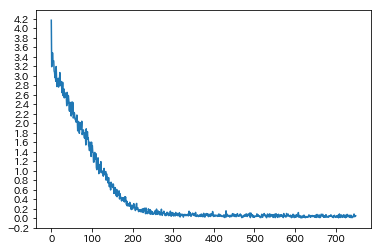

In [30]:
# 訓練イテレーション実施
train_iters(encoder1, attn_decoder1, 75000, print_every=5000)

In [31]:
# コーパスからランダムに入力文を選出し、翻訳した後その出力を原文ペアと共に出力
evaluate_randomly(encoder1, attn_decoder1)

> 彼女はのんきだ。
= she is easygoing.
< she is easygoing. <EOS>

> 彼はびくびくしている。
= he is afraid of his own shadow.
< he is afraid of his own shadow. <EOS>

> 彼は暮し向きが良い。
= he is well off.
< he is well off. <EOS>

> 私は一人っ子です。
= i am an only child.
< i am an only child. <EOS>

> 彼はかんかんに怒っている。
= he is boiling with rage.
< he is very angry. <EOS>

> 彼は私の古い友達です。
= he is my old friend.
< he is my old friend. <EOS>

> 彼女は靴にたくさん金を使う。
= she spends a lot of money on shoes.
< she spends a lot of money on shoes. <EOS>

> 彼女は遅刻魔だ。
= she is habitually late.
< she is habitually late. <EOS>

> 彼は親しい友人だ。
= he is my close friend.
< he is my close friend. <EOS>

> 彼らは始めるところです。
= they are about to start.
< they are about to start. <EOS>



In [32]:
# サンプル文に対する出力文表示
output_words, attentions = evaluate(encoder1, attn_decoder1, "彼は生まれつき寛大な人だ。")

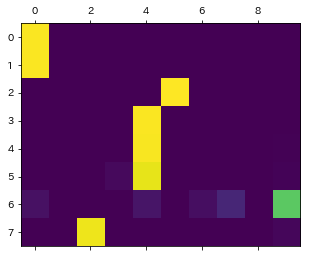

In [33]:
# アテンションの描画
plt.matshow(attentions.numpy())

input = 彼は見聞の広い人だ。
output = he is a well informed person. <EOS>


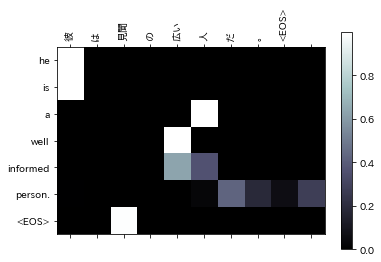

In [34]:
# テスト 1
evaluate_and_show_attention("彼は見聞の広い人だ。")

input = 私はちょうど散歩に出かけるところです。
output = i am just going for a walk. <EOS>


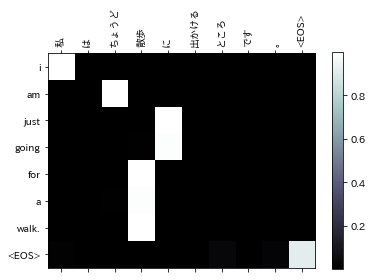

In [35]:
# テスト 2
evaluate_and_show_attention("私はちょうど散歩に出かけるところです。")

input = 彼女は彼より頭がいい。
output = she is smarter than he is. <EOS>


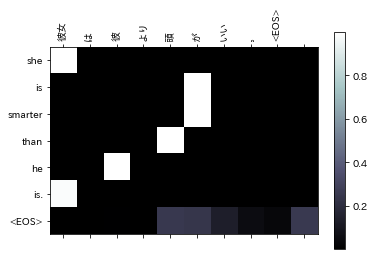

In [36]:
# テスト 3
evaluate_and_show_attention("彼女は彼より頭がいい。")